# Acoustic Wave propagation in a composite 2D field
## Libraries import

In [1]:
import numpy as np
from devito import *
import matplotlib.pyplot as plt
from GenerateVideo import generate_video
from examples.cfd import init_smooth
from ColorMap import get_seismic_cmap

## Parameters:
- $nx$ the number of points in the meshgrid side
- $dt$ the interval to compute the steps in the simulation
- $seconds$ the number of seconds of the simulation

In [2]:
nx = 64
dt = 0.01*(1/32)
seconds = 10
nt = int(seconds/dt)
nb_images = nt//100

grid = Grid(shape=(nx, nx), extent=(1., 1.))

## Initial condition
We start from a gaussian distribution centered in the field. $c$ is the wave propagation coefficient. Since it is variable across the field, it is represented as a function $c(x, y)$.

In [14]:
u = TimeFunction(name='u', grid=grid, space_order=2, save=nt, time_order=2)
c = Function(name='c', grid=grid)

c.data[:] = 0.02
c.data[5*nx//10:8*nx//10] = 0.04

for i in range(nx):
    c.data[i, :int(-(i+10)*3.5+120)] = 0.09
    
for i in range(nx):
    c.data[i, int(i*1.7)-15:] = 0.02

for i in range(nx):
    c.data[i, int((i-10)*5)-75:] = 0.035
    
c.data[2*nx//10:4*nx//10] = 0.07

for i in range(nx):
    c.data[i, :int(-i*3.5+40)] = 0.06

for i in range(nx):
    c.data[i, i*2:] = 0.05

for i in range(nx):
    c.data[i, :-i*3] = 0.03

c.data[:(nx//10)] = 0.1

x, y = np.ogrid[:nx, :nx]
distance_from_center = np.sqrt((x - nx/2)**2 + (y - nx/2)**2)

u.data[0][distance_from_center <= nx//12] = -0.001
u.data[0][distance_from_center <= nx//16] = 0.001

In [15]:
cmap = get_seismic_cmap()

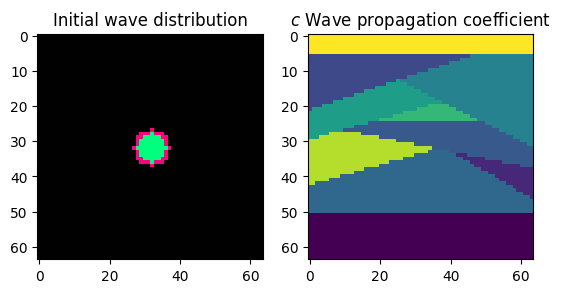

In [16]:
fig, ax0 = plt.subplots(1, 2)
ax0[0].imshow(u.data[0], vmin=-np.max(np.abs(u.data)), vmax=np.max(np.abs(u.data)), cmap=cmap)
ax0[0].set_title("Initial wave distribution")
ax0[1].imshow(c.data, vmin=np.min(c.data), vmax=np.max(c.data), cmap="viridis")
ax0[1].set_title(r"$c$ Wave propagation coefficient")
plt.show()

## Equation
The PDE we want to solve is 
$$\frac{d^2u}{dt^2} = c^2 (\frac{d^2u}{dx^2}+\frac{d^2u}{dy^2})$$

In [17]:
eq = Eq(u.dt2, (c**2)*(u.dx2+u.dy2))
stencil = solve(eq, u.forward)

Which yields the following solution for $u(x, y, t+dt)$:

In [18]:
stencil

dt**2*((Derivative(u(time, x, y), (x, 2)) + Derivative(u(time, x, y), (y, 2)))*c(x, y)**2 - (-2.0*u(time, x, y)/dt**2 + u(time - dt, x, y)/dt**2))

We build an operator that binds $u(x, y, t+dt)$ with this solution:

In [19]:
op = Operator(Eq(u.forward, stencil), opt='noop')

We apply the numerical solver:

In [20]:
op.apply(dt=dt)

Operator `Kernel` ran in 0.12 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.11622100000005078, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

## Solutions
We plot the evolution through time for the initial condition:

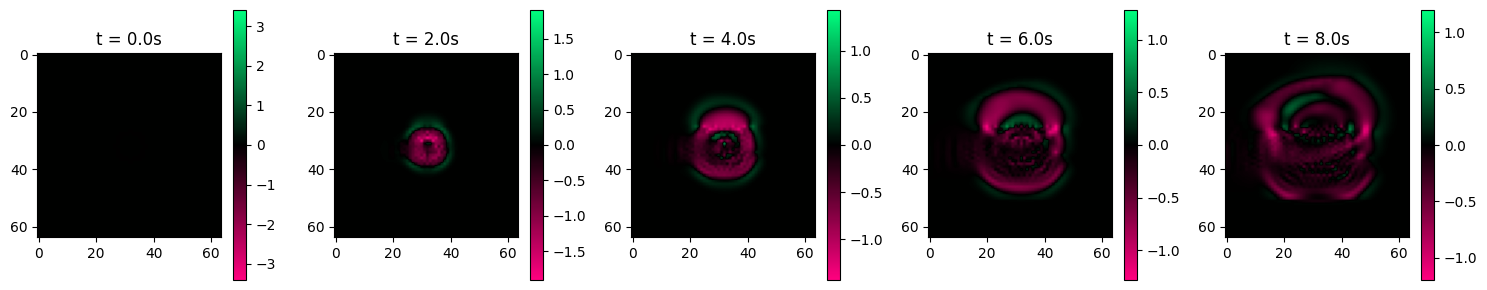

In [21]:
num_examples = 5
fig, ax = plt.subplots(1, num_examples, figsize=(15, 3))
for i in range(num_examples):
    x = ax[i].imshow(u.data[i*(u.data.shape[0]//num_examples)], 
                     vmin=-np.max(np.abs(u.data[i*(u.data.shape[0]//num_examples):])), 
                     vmax=np.max(np.abs(u.data[i*(u.data.shape[0]//num_examples):])), 
                     cmap=cmap)
    ax[i].set_title("t = " + str(i*(u.data.shape[0]//num_examples)*dt) + "s")
    fig.colorbar(x)
plt.tight_layout()
plt.show()

The solution can also be visualised through a video:

In [24]:
generate_video(u.data[::nt//(nb_images//10)], "wave_test", dt=nt*dt/(nb_images//10), verbose=True)

Generating 32 images.


  0%|          | 0/32 [00:00<?, ?it/s]

In [25]:
%%HTML
<video width="640" controls>
  <source src="wave_test.mp4" type="video/mp4">
</video>